Марат Насрутдинов 

Задание

1. Скачайте данные с Kaggle по ценам на жильё в Airbnb в Нью-Йорке:
https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data

2. Пройдите по основным шагам работы с данными - базовые статистики, визуализации (распределения, корреляции, pair plots), предобработка переменных.

Переменные, которые пока нужно убрать: id, name, host_id, host_name, last_review.

Обратите внимание на распределение целевой переменной.

Во время предобработки не забудьте закодировать категориальные переменные (one-hot encoding, можно использовать pd.get_dummies) и прошкалировать непрерывные.

Бонусное задание по предобработке - найдите координаты центра Нью-Йорка и при помощи евклидового расстояния создайте новую переменную "center_distance" используя широту и долготу центра и текущей квартиры. Этот признак для линейной регрессии будет работать гораздо лучше, чем просто широта и долгота, так что их можно будет спокойно убрать из датасета.

3. Отложите 30% данных для тестирования и постройте модели простой линейной регрессии, RidgeCV, LassoCV и ElasticNetCV. Измерьте качество каждой и визуализируйте важность признаков. Сделайте интересные выводы :)
Критерии оценки: Максимум - 10 баллов

За качественную предобработку и визуализации - 5 баллов, за настройку и визуализацию коэффициентов моделей - еще 5 баллов. 

__Подключаем библиотеки__

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


import matplotlib.pyplot as plt 
import seaborn as sns # 
%matplotlib inline

__Загружаем данные__

In [2]:
df=pd.read_csv("AB_NYC_2019.csv") 

In [3]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
id                                48895 non-null int64
name                              48879 non-null object
host_id                           48895 non-null int64
host_name                         48874 non-null object
neighbourhood_group               48895 non-null object
neighbourhood                     48895 non-null object
latitude                          48895 non-null float64
longitude                         48895 non-null float64
room_type                         48895 non-null object
price                             48895 non-null int64
minimum_nights                    48895 non-null int64
number_of_reviews                 48895 non-null int64
last_review                       38843 non-null object
reviews_per_month                 38843 non-null float64
calculated_host_listings_count    48895 non-null int64
availability_365                  48895 non-null int64

In [5]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


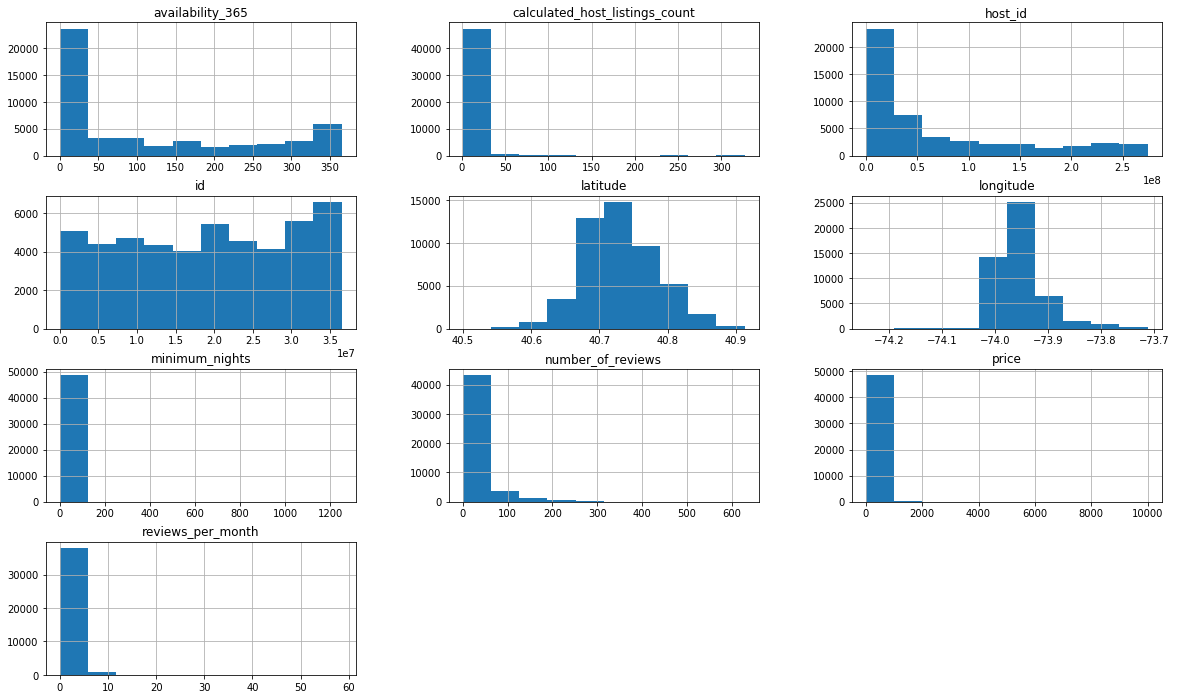

In [6]:
df.hist(figsize=(20,12));

In [7]:
#Удаление переменных 
df.drop(['id', 'name', 'host_id', 'host_name', 'last_review','neighbourhood'], axis='columns', inplace=True)

#Добавочно удаляем категорию neighbourhood, так как OHE приводит к большому количеству столбцов 
# и данные плохо интерпретируются. Кроме того название района должно коррелировать с координатами

In [8]:
#Находим NaN значения целевой переменной
df.isnull().sum()


neighbourhood_group                   0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [9]:
#аменим NaN значения 0
df=df.fillna(0);

In [10]:
df.isnull().sum()

neighbourhood_group               0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

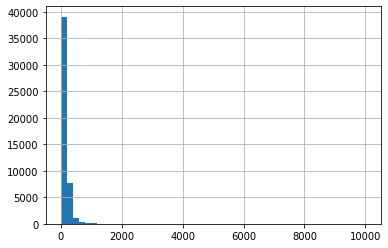

In [11]:
#Построим гистограмму цены
df.price.hist(bins=50)

In [12]:
#некоторые значения price -- 0
df[(df.price==0)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11 entries, 23161 to 26866
Data columns (total 10 columns):
neighbourhood_group               11 non-null object
latitude                          11 non-null float64
longitude                         11 non-null float64
room_type                         11 non-null object
price                             11 non-null int64
minimum_nights                    11 non-null int64
number_of_reviews                 11 non-null int64
reviews_per_month                 11 non-null float64
calculated_host_listings_count    11 non-null int64
availability_365                  11 non-null int64
dtypes: float64(3), int64(5), object(2)
memory usage: 968.0+ bytes


In [13]:
#Удаляем 11 строк с нулевым значением price
df=df.drop(df[df.price==0].index)

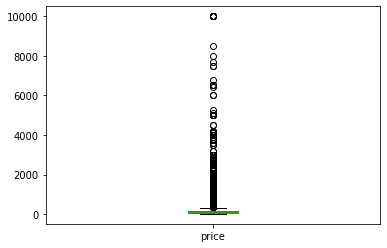

In [14]:
#Построим boxplot для целевой переменной
df.price.plot.box()

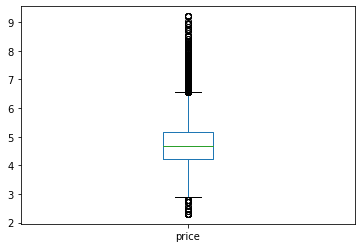

In [15]:
#Логарифмируем целевую переменную и смотрим насколько уменьшилось виляние выборосов
df['price']=np.log(df['price'])
df.price.plot.box()

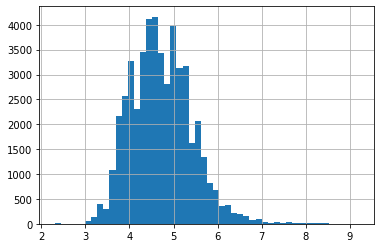

In [16]:
df.price.hist(bins=50)

Большой корелляции не наблюдается

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48884 entries, 0 to 48894
Data columns (total 10 columns):
neighbourhood_group               48884 non-null object
latitude                          48884 non-null float64
longitude                         48884 non-null float64
room_type                         48884 non-null object
price                             48884 non-null float64
minimum_nights                    48884 non-null int64
number_of_reviews                 48884 non-null int64
reviews_per_month                 48884 non-null float64
calculated_host_listings_count    48884 non-null int64
availability_365                  48884 non-null int64
dtypes: float64(4), int64(4), object(2)
memory usage: 4.1+ MB


In [18]:
# Сделаем OHE для категориальных переменных
df_categor = pd.get_dummies(df['neighbourhood_group'], drop_first=True, prefix='neighbourhood_group')

# Объединили назад наши таблички
df = pd.concat([df.drop('neighbourhood_group',axis=1),df_categor], axis=1)

#Простое раздувание категории neighbourhood приводит к большому количеству столбцов 
# и данные плохо интерпретируются, так как название района должно кореллировать с координатами, то выбросим этот столбец
    #df_categor = pd.get_dummies(df['neighbourhood'], drop_first=True, prefix='neighbourhood')
    #df = pd.concat([df.drop('neighbourhood',axis=1),df_categor], axis=1)

df_categor = pd.get_dummies(df['room_type'], drop_first=True, prefix='room_type')
df = pd.concat([df.drop('room_type',axis=1),df_categor], axis=1)

df.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Private room,room_type_Shared room
0,40.64749,-73.97237,5.003946,1,9,0.21,6,365,1,0,0,0,1,0
1,40.75362,-73.98377,5.416100,1,45,0.38,2,355,0,1,0,0,0,0
2,40.80902,-73.94190,5.010635,3,0,0.00,1,365,0,1,0,0,1,0
3,40.68514,-73.95976,4.488636,1,270,4.64,1,194,1,0,0,0,0,0
4,40.79851,-73.94399,4.382027,10,9,0.10,1,0,0,1,0,0,0,0


In [19]:
#Замена широты и долготы на расстояни от георафического центра города
#Вероятно центр можно было бы взять и как среднее от всех координат данных
coords=df[['latitude','longitude']] 
center=np.array([[40.7420,-73.9073]])

from scipy.spatial import distance

df['center_distance']=distance.cdist(coords, center, 'euclidean')

In [20]:
#Удаление переменных 
df.drop(['latitude','longitude'], axis='columns', inplace=True)

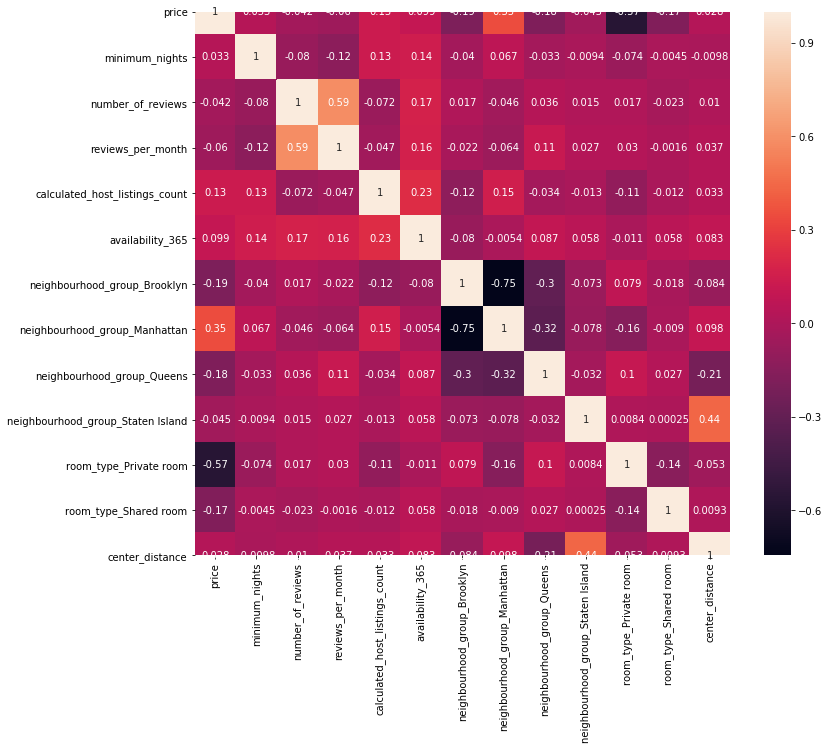

In [21]:
#Построим матрицу корреляций
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True);

In [22]:
#Делим данные на тренировочные и тестовые 30% 
#данных откладываем для тестирования качества модели. Остальные 70% берём для обучения.
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size = 0.3)

In [23]:
from sklearn.preprocessing import StandardScaler

# объявили скалировщик
scaler = StandardScaler()

# учим скалировщик скалировать все переменны на трэйне
list_of_data=['price', 'minimum_nights', 'number_of_reviews', 
              'reviews_per_month', 'calculated_host_listings_count', 'availability_365','center_distance']
scaler.fit(df_train[list_of_data]) 

StandardScaler(copy=True, with_mean=True, with_std=True)

In [24]:
# Применяем скалировщик к трэйну
df_train_scale = scaler.transform(df_train[list_of_data])

# Применяем скалировщик к тесту 
df_test_scale = scaler.transform(df_test[list_of_data])

In [25]:
df_train[list_of_data]=df_train_scale
df_test[list_of_data]=df_test_scale
    
    

In [26]:
df_train.head()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Private room,room_type_Shared room,center_distance
11259,-0.173251,-0.287846,-0.208590,-0.487912,-0.185517,-0.173962,0,0,1,0,0,0,0.134516
32242,-0.036784,-0.096325,-0.474584,-0.587088,-0.185517,-0.812190,0,1,0,0,1,0,-0.339738
12861,-0.904661,-0.192085,-0.430252,-0.599485,-0.185517,-0.857777,1,0,0,0,1,0,-0.366156
4024,-0.103392,-0.287846,-0.496750,-0.667669,-0.185517,-0.857777,1,0,0,0,1,0,0.146743
27436,0.407302,-0.192085,-0.452418,-0.580890,-0.154994,-0.857777,0,0,1,0,0,0,-1.664476


In [27]:
print(df_train.shape) # Посмотрим на размеры трэйна и теста 
print(df_test.shape)

(34218, 13)
(14666, 13)


In [28]:
# Вытаскиваем цены и параметры квартир по разным переменным для удобства 

y_train = df_train.price 
y_test = df_test.price 

X_train = df_train.drop('price', axis=1).get_values()
X_test = df_test.drop('price', axis=1).get_values()

In [29]:
y_mean = np.mean(y_train)                     # посчитали среднее 
y_pred_naive = np.ones(len(y_test)) * y_mean  # спрогнозировали им цену всех квартир в тестовой выборке
y_pred_naive[:5]

array([1.89965655e-16, 1.89965655e-16, 1.89965655e-16, 1.89965655e-16,
       1.89965655e-16])

__Метрики качества__

In [30]:
from sklearn import metrics  # подгружаем метрики

In [31]:
metrics.mean_absolute_error(y_test, y_pred_naive)

0.7921281146557838

In [32]:
metrics.mean_absolute_error(np.exp(y_test), np.exp(y_pred_naive))

1.6197152368060608

__Модели простой линейной регрессии, RidgeCV__

In [33]:
from sklearn.linear_model import LinearRegression

# Объявили модель
model_regression = LinearRegression()

# Обучили модель на тренировочной выборке 
model_regression.fit(X_train, y_train)

# Сделали прогнозы на тестовой выборке 
y_pred_regr = model_regression.predict(X_test)

In [34]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_test, y_pred_naive)

100.0

In [35]:
def print_metrics(y_test,y_pred):
    print('MAE:', metrics.mean_absolute_error(np.exp(y_test), np.exp(y_pred)))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(np.exp(y_test), np.exp(y_pred))))
    print('R2:',  metrics.r2_score(y_test, y_pred))
    print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))
    pass

In [36]:
print_metrics(y_test,y_pred_regr)



MAE: 1.3659185584241946
RMSE: 12.167293953879906
R2: 0.4709574314917966
MAPE: 172.7637911756321


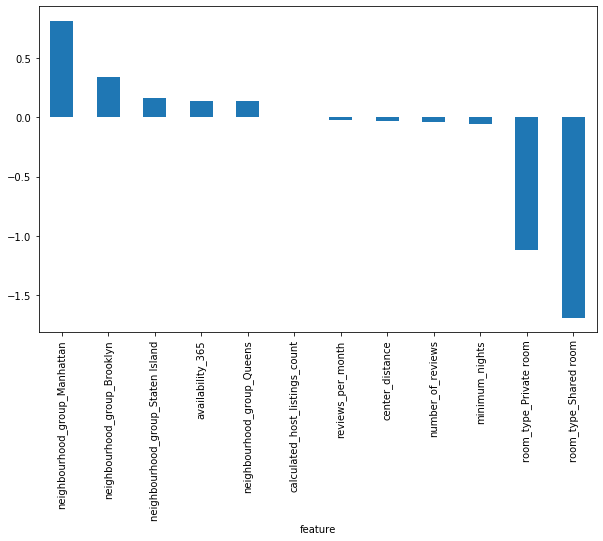

In [37]:
featureImportance = pd.DataFrame({"feature": df.drop('price',axis=1).columns, 
                                  "importance": model_regression.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot('bar', figsize=(10, 6));

Наибольший вклад в цену дает близость к району Манхетена и Бруклина, уменьшает цену тип комнат "общий". Видимо пользоватлеи предпочитают Entire home/apt. Можно было бы посмотреть внимательнее на "neighbourhood", который выбросили для выявления престижных районов.  

__Модели простой линейной регрессии Lasso__

In [38]:
from sklearn.linear_model import Lasso

# Объявили модель
model_simplelasso = Lasso()

# Обучили модель на тренировочной выборке 
model_simplelasso.fit(X_train, y_train)

# Сделали прогнозы на тестовой выборке 
y_pred_lasso = model_simplelasso.predict(X_test)

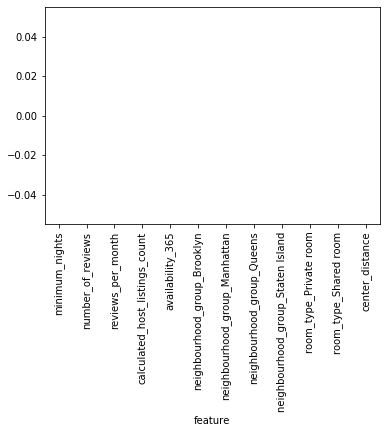

In [39]:
featureImportance = pd.DataFrame({"feature": df.drop('price',axis=1).columns, 
                                  "importance": model_simplelasso.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot('bar');

In [40]:
from sklearn.model_selection import GridSearchCV

# Решётака для перебора параметра 
param_grid = {'alpha': [0.001, 0.01, 0.05, 0.1, 0.5, 0.8, 1, 5, 10]}

# Объявили модель 
model_lasso = Lasso() 

# Объявили перебор 
grid_cv_lasso = GridSearchCV(model_lasso, param_grid, cv = 5)
grid_cv_lasso.fit(X_train, y_train)
print('Лучшее значение параметра:', grid_cv_lasso.best_params_)

# Сделали прогнозы
y_pred_lasso = grid_cv_lasso.predict(X_test)

Лучшее значение параметра: {'alpha': 0.001}


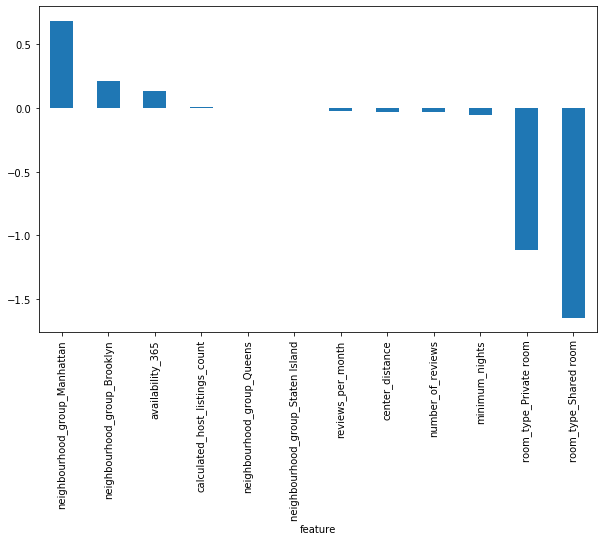

In [41]:
featureImportance = pd.DataFrame({"feature": df.drop('price',axis=1).columns, 
                                  "importance": grid_cv_lasso.best_estimator_.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot('bar', figsize=(10, 6));

In [42]:
print_metrics(y_test,y_pred_lasso)

MAE: 1.3658299404057457
RMSE: 12.168176991443257
R2: 0.47084884595032483
MAPE: 171.91935933420677


__Модели простой линейной регрессии LassoCV__

In [43]:
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(cv=5)
lasso_cv.fit(X_train, y_train)
print('Лучшее значение параметра:', lasso_cv.alpha_)

# Сделали прогнозы
y_pred_lasso_cv = lasso_cv.predict(X_test)

Лучшее значение параметра: 0.00028205604592641543


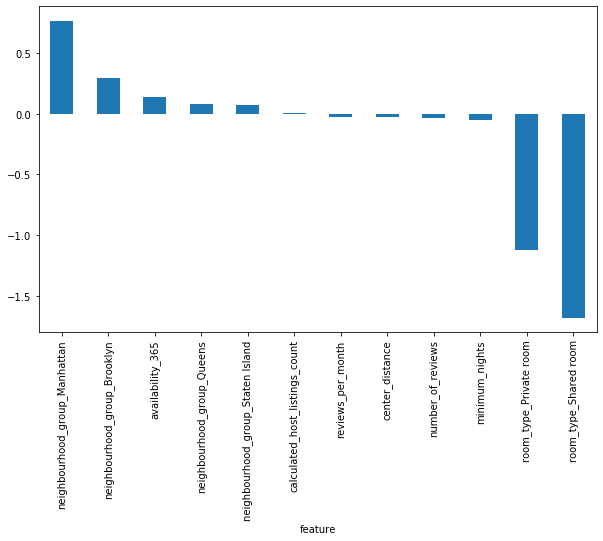

In [44]:
featureImportance = pd.DataFrame({"feature": df.drop('price',axis=1).columns, 
                                  "importance": lasso_cv.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot('bar', figsize=(10, 6));

__Модели простой линейной регрессии ElasticNetCV__

In [45]:
from sklearn.linear_model import ElasticNet

In [46]:
ENet_cv = ElasticNet(alpha=0.1)
ENet_cv.fit(X_train, y_train)
#print('Лучшее значение параметра:', ElasticNet_cv. .alpha_)

# Сделали прогнозы
y_pred_ENet_cv = ENet_cv.predict(X_test)



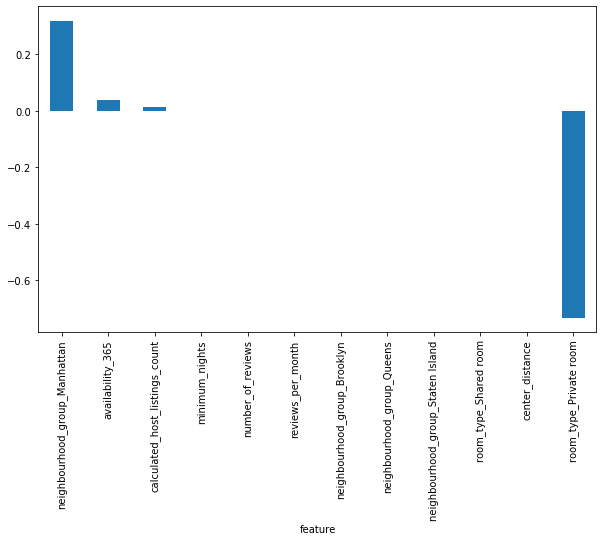

In [47]:
featureImportance = pd.DataFrame({"feature": df.drop('price',axis=1).columns, 
                                  "importance": ENet_cv.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot('bar', figsize=(10, 6));

В этой модели значимыми параметрами явялется только принадлежность к Манхетену, доступность в течение года. Отрицательным значенияем является тип private_room

In [48]:
print_metrics(y_test,y_pred_ENet_cv)

MAE: 1.4198946446078433
RMSE: 12.207098345998933
R2: 0.35273353821682296
MAPE: 131.1527323181026
